In [ ]:
%env ALL_PROXY=http://127.0.0.1:33001
%env HTTP_PROXY=http://127.0.0.1:33001
%env HTTPS_PROXY=http://127.0.0.1:33001

In [ ]:
!curl google.com

# Import

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import wandb

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.insert(0, "/root/Soil-Column-Procedures")

from API_functions.DL import load_data, log, seed
from API_functions import file_batch as fb

# Hyperparameter and log

In [3]:
my_parameters = {
    'seed': 409,

    'Kfold': None,
    'ratio': 0.2,

    'model': '???',
    'optimizer': 'adam',
    'learning_rate':  0.0001,
    'batch_size': 32,
    'loss_function': 'cross_entropy',

    'n_epochs': 1000,
    'patience': 50,
}

device = 'cuda'
mylogger = log.Logger('all')

seed.stablize_seed(my_parameters['seed'])

In [ ]:
wandb.init(
    project="U-Net",
    name='10.using albumentations',
    config=my_parameters,
)

# Transform

In [ ]:
# # Define transformations and dataset
# transform_common = v2.Compose([
#     v2.ToTensor(),
#     v2.ToDtype(torch.float32),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.5),
#     v2.RandomRotation(degrees=90),
# ])

# transform_train_special = v2.Compose([
#     v2.Normalize(mean=[0.5], std=[0.5]),
#     # v2.ColorJitter(brightness=0.1, contrast=0.1)
# ])

# transform_train = v2.Compose([
#     transform_common,
#     transform_train_special
# ])

# transform_train_label = transform_common

# transform_val = v2.Compose([
#     v2.ToTensor(),
#     v2.ToDtype(torch.float32)
# ])

# transform_test = transform_val

In [5]:
# For training data
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    # A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# For validation and test data
transform_val = A.Compose([
    ToTensorV2(),
])

# Load_data

In [6]:
def load_images(paths):
    return [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in paths]

data_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_images/', None, 'png')
labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/train_labels/', None, 'png')
test_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_images/', None, 'png')
test_labels_paths = fb.get_image_names('/root/Soil-Column-Procedures/data/version0/test_labels/', None, 'png')

data = load_images(data_paths)
labels = load_images(labels_paths)
tests = load_images(test_paths)
test_labels = load_images(test_labels_paths)

train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=my_parameters['ratio'], random_state=my_parameters['seed'])

train_dataset = load_data.my_Dataset(train_data, train_labels, transform=transform_train)
val_dataset = load_data.my_Dataset(val_data, val_labels, transform=transform_val)
test_dataset = load_data.my_Dataset(tests, test_labels, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=my_parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=my_parameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=my_parameters['batch_size'], shuffle=False)

print(f'len of train_data: {len(train_data)}, len of val_data: {len(val_data)}, len of test_data: {len(tests)}')

10 images have been found in /root/Soil-Column-Procedures/data/version0/train_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_images/002_ou_DongYing_12635.png
Get names completely!
10 images have been found in /root/Soil-Column-Procedures/data/version0/train_labels/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12633.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12634.png
/root/Soil-Column-Procedures/data/version0/train_labels/002_ou_DongYing_12635.png
Get names completely!
5 images have been found in /root/Soil-Column-Procedures/data/version0/test_images/
The first 3 images are:
/root/Soil-Column-Procedures/data/version0/test_images/002_ou_DongYing_13635_roi_selected.png
/root/Soil-Column-Procedures/data/version0

# Model

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, smooth=1):
        # First, calculate the BCE loss
        inputs = torch.sigmoid(inputs)
        bce_loss = self.bce(inputs, targets)
        
        # Calculate Dice Loss
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        # Combine BCE + Dice
        return 0.5 * bce_loss + 0.5 * dice_loss

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

In [ ]:
# model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=my_parameters['learning_rate'])
criterion = DiceBCELoss()

# Train

In [ ]:
val_loss_best = 100000

for epoch in range(my_parameters['n_epochs']):
    model.train()
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if outputs.dim() == 4 and outputs.size(1) == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss_mean = train_loss / len(train_loader.dataset)


    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            if outputs.dim() == 4 and outputs.size(1) == 1:
                outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)

    val_loss_mean = val_loss / len(val_loader.dataset)
    dict = {'train_loss': train_loss_mean, 'epoch': epoch, 'val_loss': val_loss_mean}
    mylogger.log(dict)

    if val_loss_mean < val_loss_best:
        val_loss_best = val_loss_mean
        torch.save(model.state_dict(), 'model.pth')
        print(f'Model saved at epoch {epoch}, val_loss: {val_loss_mean}')

In [ ]:
wandb.finish()

# Test

In [7]:
def save_image(image, path):
    """Save a tensor as an image."""
    image = image.squeeze().cpu().numpy()
    plt.imsave(path, image, cmap='gray')

def test_model(model, test_loader, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            outputs = outputs > 0.5  # Threshold the probabilities to create a binary mask
            
            # Save output images
            for idx, output in enumerate(outputs):
                save_path = f'/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/002_ou_DongYing_{i*test_loader.batch_size + idx + 13635}_roi_selected.png'
                save_image(output, save_path)

            print(f'Processed batch {i+1}/{len(test_loader)}')


In [8]:
# Test the model
model = smp.Unet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)
test_model(model, test_loader)

/tmp/ipykernel_10714/316332847.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
/root/Soil-Column-Procedures/API_functions/

Processed batch 1/1


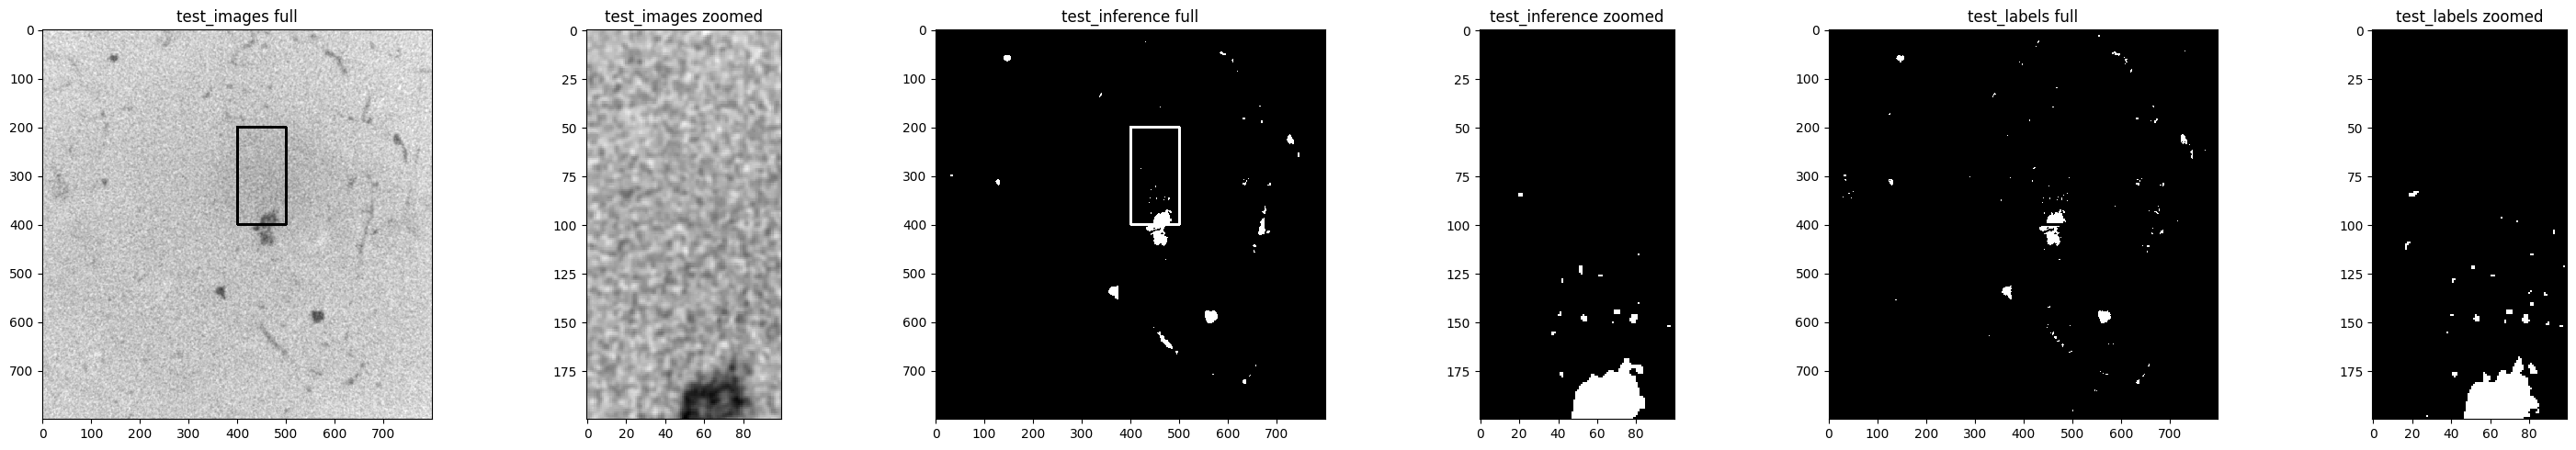

In [9]:
from API_functions.Visual import file_compare as fc
# %matplotlib qt

db = fc.ImageDatabase()
# image_processor.add_result('pre_processed', tpi.user_threshold(image_processor.image, 160))
zoom = fc.ZoomRegion(200, 400, 100, 200)
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_images/', 'test_images')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/test_labels/', 'test_labels')
db.add_additional_folder('/root/Soil-Column-Procedures/data/version0/inference/tests_inference6/', 'test_inference')
image_processor = db.get_image_processor('002_ou_DongYing_13636_roi_selected.png')
image_processor.show_images('test_images', 'test_inference', 'test_labels', zoom_region=zoom)